# Reconhecimento Multirrótulo de Acessórios, Gênero e Cores de Vestuário em Ambientes Dinâmicos

Bacharelado em Ciência da Computação / PUCPR

Prof. Rayson Laroca

Arthur Palma - `palma.arthur@pucpr.edu.br`

Cesar Albuquerque - `cesar.albuquerque@tecpuc.com.br`

Matheus Reich - `matheus.zagonel@pucpr.edu.br`

Matheus Kozak - `kozak.matheus@pucpr.edu.br`

Paula Henriques - `henriques.paula@pucpr.edu.br`

2025

## Imports e dataset

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import tensorflow_datasets as tfds
import os, csv
from collections import Counter
import random
from PIL import Image, ImageOps
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import confusion_matrix

In [ ]:
# DataSet: https://pucpredu-my.sharepoint.com/personal/rayson_santos_pucpr_br/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Frayson%5Fsantos%5Fpucpr%5Fbr%2FDocuments%2FPAR2025%2Ezip&parent=%2Fpersonal%2Frayson%5Fsantos%5Fpucpr%5Fbr%2FDocuments&ga=1


In [ ]:
# Baixando o repositório como um arquivo ZIP

os.system("wget https://github.com/MatheusKozak/Clothing-Detection-Challenge/archive/refs/heads/main.zip -O Clothing-Detection-Challenge.zip")

# Descompacta apenas as pastas training_set e validation_set
# Tempo normal para baixar e descompactar é de 3/4 min
os.system("unzip -j Clothing-Detection-Challenge.zip 'Clothing-Detection-Challenge-main/training_set/*' -d training_set")
os.system("unzip -j Clothing-Detection-Challenge.zip 'Clothing-Detection-Challenge-main/validation_set/*' -d validation_set")

0

## Análise e visualização de conjuntos de dados

*   COR DAS ROUPAS: as cores disponíveis são preto, azul, marrom, cinza, verde, laranja, rosa, roxo, vermelho, branco e amarelo, representadas pelas etiquetas [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11].
*   GÊNERO: classificado como masculino ou feminino, representado por [0, 1]
*   BOLSA: indica se há ou não uma bolsa, representado por [0, 1].
*   CHAPÉU: indica se há ou não um chapéu, representado por [0, 1].

Contagem de Cor da parte superior Counter({'black': 34223, 'blue': 14222, 'white': 12002, 'gray': 9854, 'red': 7814, 'green': 4667, 'brown': 2872, 'purple': 2631, 'yellow': 2504, 'pink': 2218, 'orange': 1287})
 Qunatidade 94294


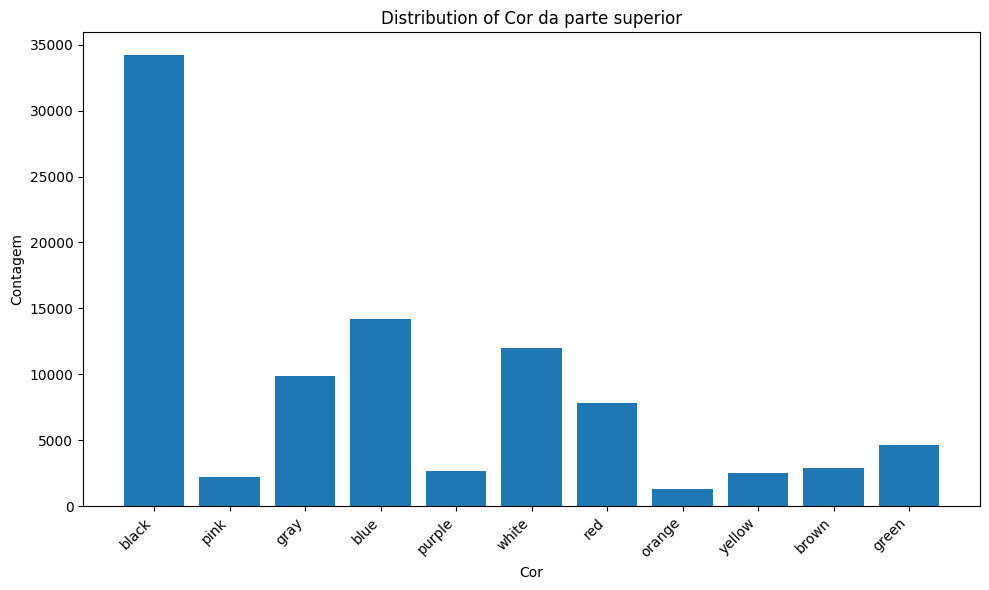

Contagem de Cor da parte inferior Counter({'black': 52861, 'blue': 22431, 'gray': 12007, 'white': 1738, 'green': 1348, 'brown': 1251, 'yellow': 962, 'red': 852, 'pink': 363, 'purple': 273, 'orange': 208})
 Qunatidade 94294


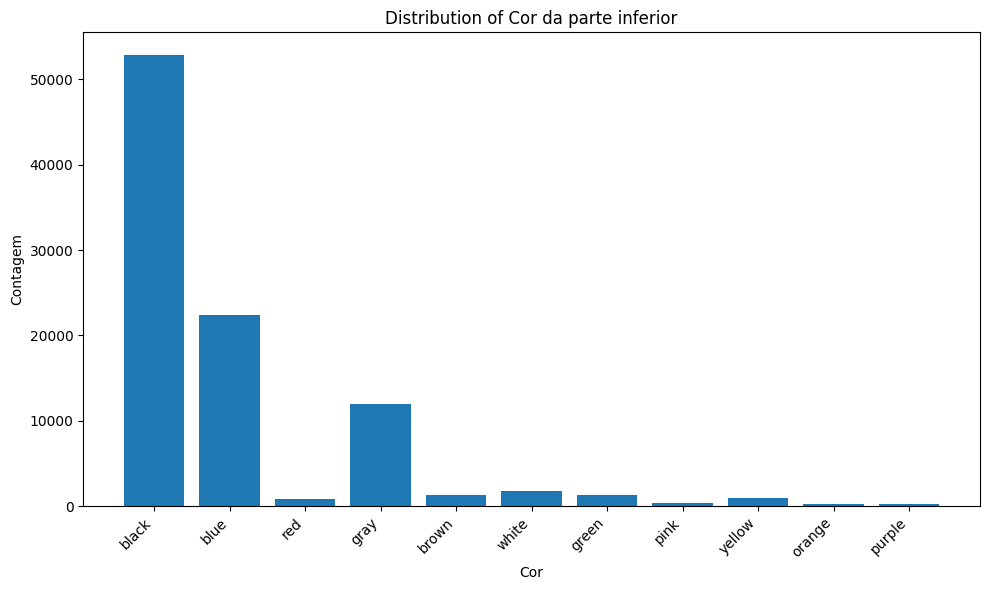

Contagem de Genero Counter({'male': 67436, 'female': 26858})
 Qunatidade 94294


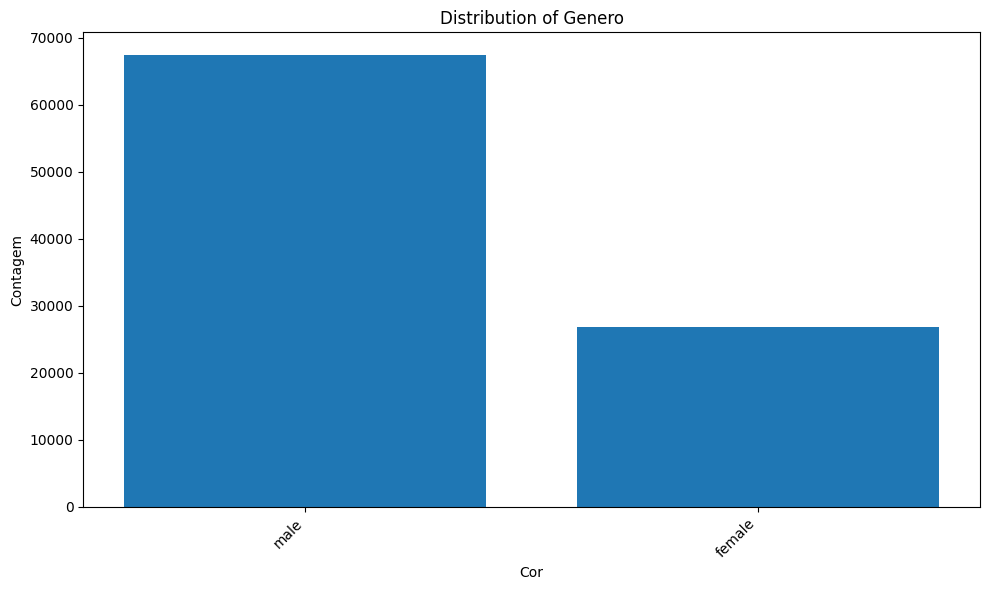

Contagem de Tem Bolsa Counter({'not present': 62455, 'present': 31839})
 Qunatidade 94294


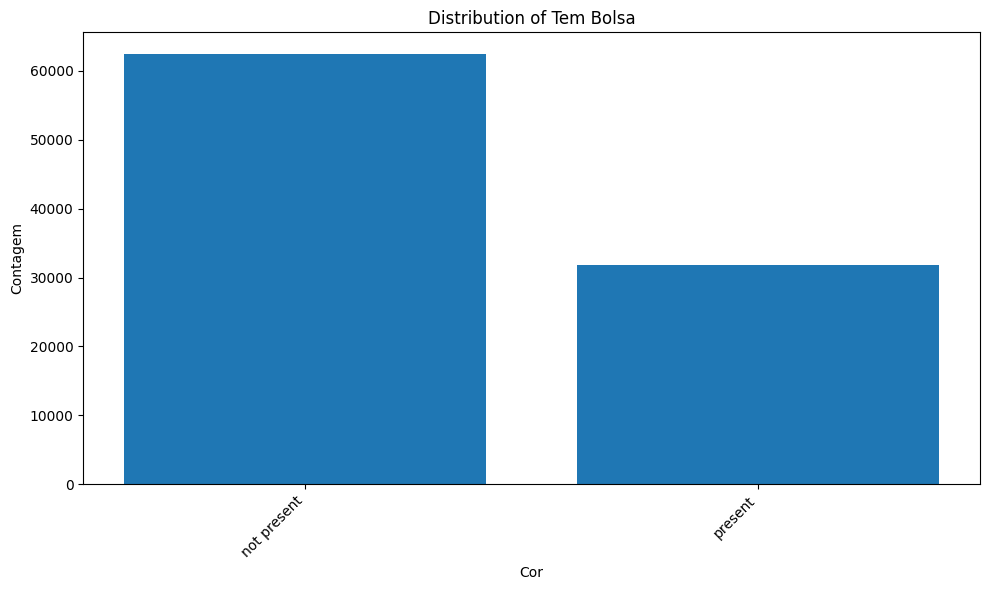

Contagem de Tem Chapéu Counter({'not present': 74352, 'present': 19942})
 Qunatidade 94294


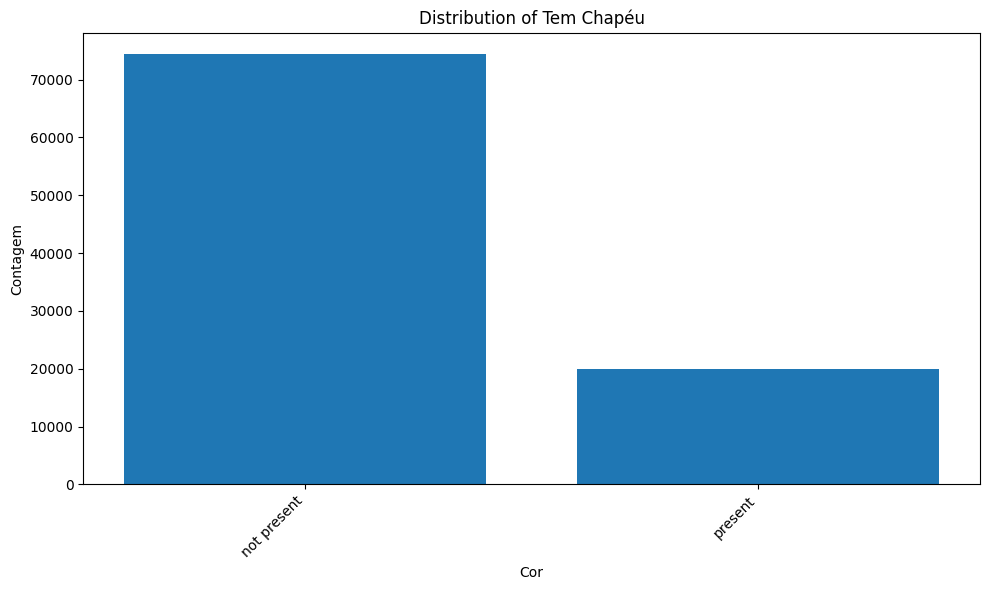

In [ ]:
dict_label_color = {
    '1': "black",
    '2': "blue",
    '3': "brown",
    '4': "gray",
    '5': "green",
    '6': "orange",
    '7': "pink",
    '8': "purple",
    '9': "red",
    '10': "white",
    '11': "yellow",
}

dict_label_binary = {
    '0': "not present",
    '1': "present",
}

dict_label_gender = {
    '1': "female",
    '0': "male",
}
file_content = ""

# Usando o arquivo de rótulo para traçar a distribuição de classe
with open('training_set/training_set.txt', 'r') as f:
  file_content = f.read()

def plot_class_dist(index , title , dict_labels):
  lines = file_content.splitlines()

  # Obtenha com segurança o segundo elemento se a linha tiver pelo menos dois elementos após a divisão por vírgula
  elements = [line.split(',')[index] for line in lines if line and len(line.split(',')) > 1]


  # Mapeie números para colorir nomes
  color_names = [dict_labels.get(num, "unknown") for num in elements]

  # Conte as ocorrências de cada cor
  color_counts = Counter(color_names)

  print(f'Contagem de {title} {color_counts}\n Qunatidade {sum(color_counts.values())}')

  # Trace a distribuição de cores
  plt.figure(figsize=(10, 6))
  plt.bar(color_counts.keys(), color_counts.values())
  plt.xlabel("Cor")
  plt.ylabel("Contagem")
  plt.title(f'Distribution of {title}')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

plot_class_dist(1 , "Cor da parte superior" , dict_label_color)
plot_class_dist(2 , "Cor da parte inferior" , dict_label_color)
plot_class_dist(3 , "Genero" , dict_label_gender)
plot_class_dist(4 , "Tem Bolsa" , dict_label_binary)
plot_class_dist(5 , "Tem Chapéu" , dict_label_binary)


Vieses:

Como há significativamente mais homens neste conjunto de dados, e eles normalmente não usam cores brilhantes, o modelo pode ter um viés maior em direção a cores mais escuras e neutras.

E, como podemos ver, entre as cores mais usadas, o preto é a mais prevalente, com uma grande vantagem. No entanto, isso é apenas correlação, não causalidade.

Além disso, como há mais homens, e eles não usam bolsas, a variável "tem bolsa" também pode ser enviesada.

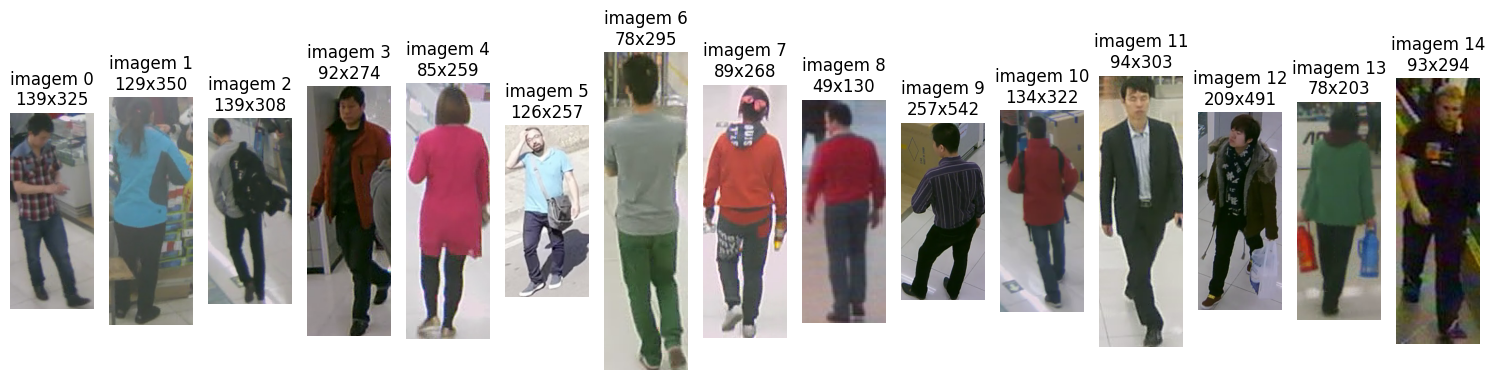

In [ ]:
# Listar todos os arquivos no diretório training_set
image_files = [f for f in os.listdir('training_set') if os.path.isfile(os.path.join('training_set', f))]

# Selecione algumas imagens aleatórias
num_images_to_display = 15
random_images = random.sample(image_files, min(num_images_to_display, len(image_files)))

# Exibir as imagens
plt.figure(figsize=(15, 5))
for i, image_name in enumerate(random_images):
    image_path = os.path.join('training_set', image_name)
    img = cv2.imread(image_path)
    if img is not None:
        height, width, _ = img.shape
        plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f'imagem {i}\n{width}x{height}')
        plt.axis('off')
    else:
        print(f"Não conseguiu ler a imagem: {image_name}")

plt.tight_layout()
plt.show()

## Divisão de conjunto de dados

Somando os dois conjuntos de dados, temos 106.756 imagens.

Temos uma divisão de conjunto de dados apenas para validação com 12.462 imagens.

Então, nossa divisão é 90/10, decidida pelo PAR2025.

In [ ]:
random.shuffle(image_files)

total_files = len(image_files)


train_split = int(0.9 * total_files*0.1)
smaller_for_test = image_files[:train_split]

total_files_small = len(smaller_for_test)
train_split = int(0.9 * total_files_small)


train_files = smaller_for_test[:train_split]
test_files = smaller_for_test[train_split:]

print(f"Total de imagens: {total_files}")
print(f"Treino: {len(train_files)}")
print(f"Teste: {len(test_files)}")

Total de imagens: 94282
Treino: 7636
Teste: 849


## Padronizando os tamanhos da imagem

Total de imagens (origem): 94281
Subconjunto usado (≈9%):  84852
Treino (90% do subset):   76366 -> training_set_resized_128
Teste  (10% do subset):   8486  -> teste_set_resized_128


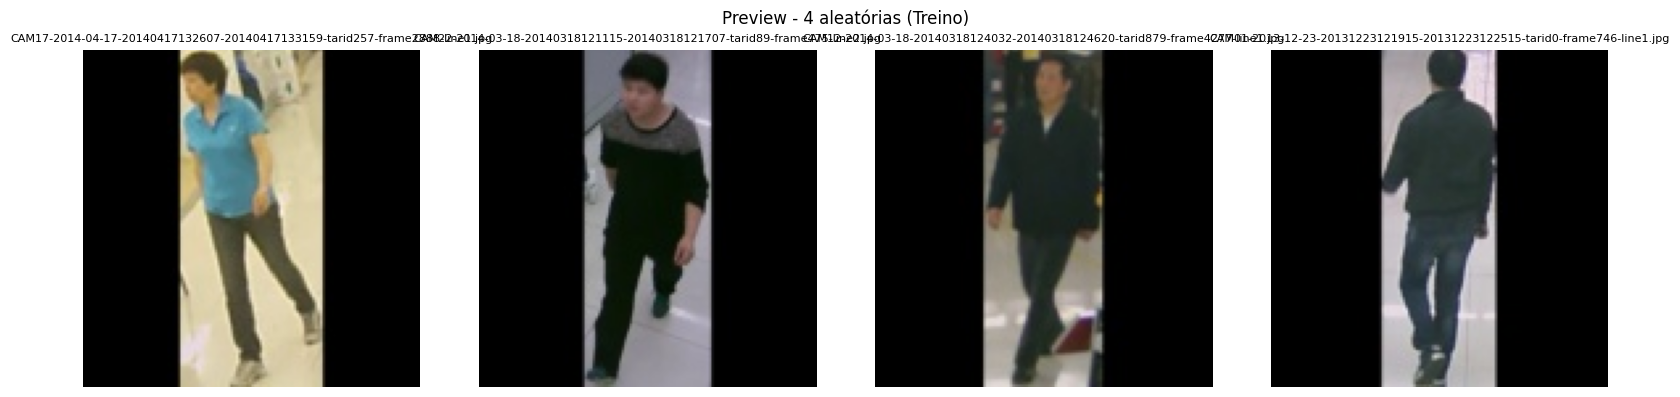

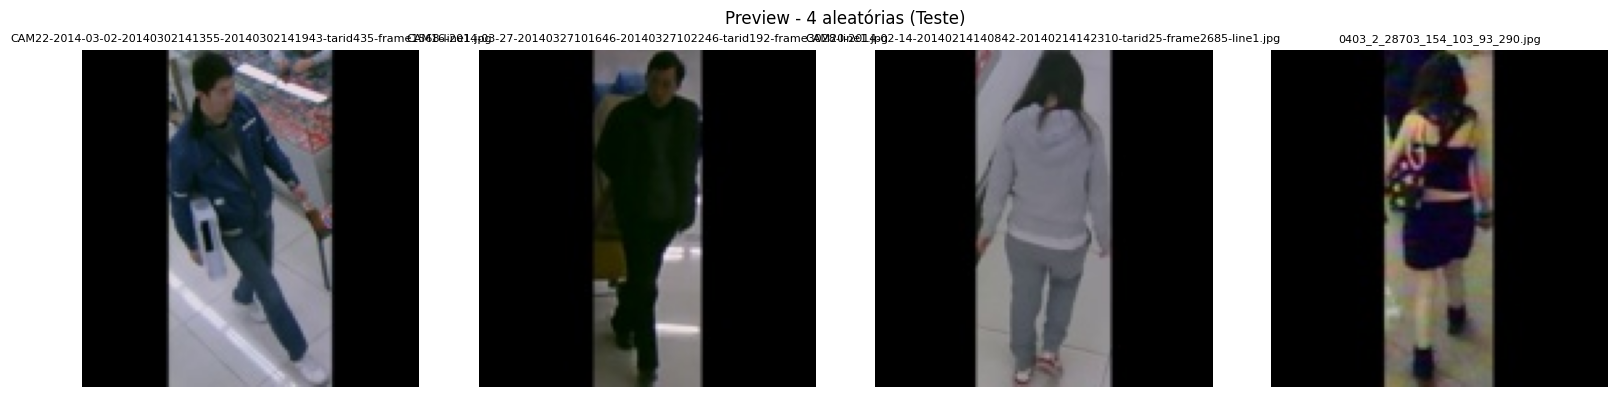

In [ ]:
IMAGE_SIZE = 128
SEED = 42
SRC_DIR = "training_set"
OUT_TRAIN = f"training_set_resized_{IMAGE_SIZE}"
OUT_TEST  = f"teste_set_resized_{IMAGE_SIZE}"
VALID_EXT = (".jpg", ".jpeg", ".png")

class PadToSquare:
    def __call__(self, img: Image.Image) -> Image.Image:
        w, h = img.size
        if w == h:
            return img
        side = max(w, h)
        dw = (side - w) // 2
        dh = (side - h) // 2
        padding = (dw, dh, side - w - dw, side - h - dh)
        return ImageOps.expand(img, padding, fill=0)

def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

def save_processed(img_path: str, dst_root: str, image_size: int, padder: PadToSquare):
    ensure_dir(dst_root)
    base = os.path.splitext(os.path.basename(img_path))[0]
    ext = ".jpg"
    out_path = os.path.join(dst_root, base + ext)
    i = 1
    while os.path.exists(out_path):
        out_path = os.path.join(dst_root, f"{base}_{i}{ext}")
        i += 1
    img = Image.open(img_path).convert("RGB")
    img = padder(img)
    img = img.resize((image_size, image_size), Image.BILINEAR)
    img.save(out_path, quality=95)
    return out_path

def preview(paths, k, title):
    if not paths:
        print(f"Sem imagens para preview: {title}")
        return
    sample = random.sample(paths, min(k, len(paths)))
    cols = min(4, k)
    rows = (len(sample) + cols - 1) // cols
    plt.figure(figsize=(4*cols, 4*rows))
    for i, p in enumerate(sample):
        plt.subplot(rows, cols, i+1)
        plt.imshow(Image.open(p))
        plt.title(os.path.basename(p), fontsize=8)
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def process_like_old_snippet():
    random.seed(SEED)
    padder = PadToSquare()

    image_files = [
        f for f in os.listdir(SRC_DIR)
        if os.path.isfile(os.path.join(SRC_DIR, f)) and f.lower().endswith(VALID_EXT)
    ]
    total_files = len(image_files)
    if total_files == 0:
        print("Sem imagens na raiz de 'training_set'.")
        return

    random.shuffle(image_files)

    # 9% do total

    sub_set_size = 1
    subset_len = int(0.9 * total_files * sub_set_size)
    sub_set = image_files[:subset_len]

    # Split 90/10 desntro desse subconjunto
    total_files_small = len(sub_set)
    train_len = int(0.9 * total_files_small)
    train_files = sub_set[:train_len]
    test_files  = sub_set[train_len:]

    ensure_dir(OUT_TRAIN); ensure_dir(OUT_TEST)
    out_train_paths, out_test_paths = [], []

    for fname in train_files:
        src_path = os.path.join(SRC_DIR, fname)
        try:
            out_train_paths.append(save_processed(src_path, OUT_TRAIN, IMAGE_SIZE, padder))
        except Exception as e:
            print("Erro (train):", src_path, e)

    for fname in test_files:
        src_path = os.path.join(SRC_DIR, fname)
        try:
            out_test_paths.append(save_processed(src_path, OUT_TEST, IMAGE_SIZE, padder))
        except Exception as e:
            print("Erro (test):", src_path, e)

    print(f"Total de imagens (origem): {total_files}")
    print(f"Subconjunto usado (≈9%):  {total_files_small}")
    print(f"Treino (90% do subset):   {len(out_train_paths)} -> {OUT_TRAIN}")
    print(f"Teste  (10% do subset):   {len(out_test_paths)}  -> {OUT_TEST}")

    preview(out_train_paths, 4, "Preview - 4 aleatórias (Treino)")
    preview(out_test_paths,  4, "Preview - 4 aleatórias (Teste)")


process_like_old_snippet()

## Deep learning - CNN - ResNet18



In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAIN_DIR = OUT_TRAIN
TEST_DIR  = OUT_TEST
TRAIN_TXT = "training_set/training_set.txt"
TEST_TXT  = "training_set/training_set.txt"
BATCH_SIZE = 128
EPOCHS = 5
LR = 1e-4
TOP_COL_IDX = 1
BOTTOM_COL_IDX = 2
GENDER_COL_IDX = 3
BAG_COL_IDX = 4
HAT_COL_IDX = 5

### Parte superior da roupa

In [ ]:
NUM_CLASSES = 11

def load_topcolor_labels(txt_path):
    mapping = {}
    with open(txt_path, "r") as f:
        reader = csv.reader(f)
        for row in reader:
            if not row or len(row) < 2:
                continue
            fname = row[0].strip()
            top_color_1_11 = int(row[1].strip())
            mapping[fname] = top_color_1_11 - 1
    return mapping

train_labels = load_topcolor_labels(TRAIN_TXT)
test_labels  = load_topcolor_labels(TEST_TXT)

def list_labeled_files(img_dir, labels_dict):
    files = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg",".jpeg",".png"))]
    keep  = [f for f in files if f in labels_dict]
    return keep

train_files = list_labeled_files(TRAIN_DIR, train_labels)
test_files  = list_labeled_files(TEST_DIR,  test_labels)

if len(train_files) == 0 or len(test_files) == 0:
    raise RuntimeError("Algum split ficou vazio após cruzar arquivos com rótulos. Verifique nomes e paths.")

train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

class TopColorDataset(Dataset):
    def __init__(self, file_list, labels_dict, root_dir, transform=None):
        self.file_list = file_list
        self.labels_dict = labels_dict
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self): return len(self.file_list)

    def __getitem__(self, idx):
        fname = self.file_list[idx]
        path = os.path.join(self.root_dir, fname)
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.labels_dict[fname]
        return img, torch.tensor(label, dtype=torch.long)

train_ds = TopColorDataset(train_files, train_labels, TRAIN_DIR, transform=train_tfms)
test_ds  = TopColorDataset(test_files,  test_labels,  TEST_DIR,  transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train: {len(train_ds)} | Test: {len(test_ds)}")

# Usa pesos pré-treinados do ImageNet
def create_model(num_classes=11):
    model = models.resnet18(weights='IMAGENET1K_V1')
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, num_classes)
    return model

model = create_model(NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

def run_epoch(model, loader, train_mode=True):
    model.train() if train_mode else model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.set_grad_enabled(train_mode):
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            if train_mode: optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, labels)
            if train_mode:
                loss.backward()
                optimizer.step()
            total_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss/total, correct/total

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(model, train_loader, train_mode=True)
    te_loss, te_acc = run_epoch(model, test_loader,  train_mode=False)
    print(f"Epoch {epoch:02d}/{EPOCHS} | Train: {tr_acc*100:.1f}% | Test: {te_acc*100:.1f}%")

print(f"\nAcurácia final: {te_acc*100:.1f}%")

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        logits = model(imgs)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = ["preto","branco","azul","vermelho","verde",
               "amarelo","marrom","rosa","roxo","cinza","laranja"]

cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-12)

plt.figure(figsize=(10, 10))
plt.imshow(cm_norm, interpolation="nearest", cmap='Blues')
plt.title(f"Matriz de Confusão – Cores da Parte Superior (Acc: {te_acc*100:.1f}%)")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=class_names, rotation=45, ha="right")
plt.yticks(ticks=np.arange(NUM_CLASSES), labels=class_names)
plt.xlabel("Predito")
plt.ylabel("Real")

for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if cm_norm[i, j] > 0.01:
            color = 'white' if cm_norm[i, j] > 0.5 else 'black'
            plt.text(j, i, f"{cm_norm[i, j]*100:.0f}%",
                    ha="center", va="center", color=color, fontsize=8)

plt.tight_layout()
plt.show()

Train: 76365 | Test: 8486
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]


KeyboardInterrupt: 

### Parte inferior da roupa

In [ ]:
NUM_CLASSES = 11

def load_bottomcolor_labels(txt_path, col_idx=BOTTOM_COL_IDX):
    mapping = {}
    with open(txt_path, "r") as f:
        reader = csv.reader(f)
        for row in reader:
            if not row or len(row) <= col_idx:
                continue
            fname = row[0].strip()
            bottom_color_1_11 = int(row[col_idx].strip())
            mapping[fname] = bottom_color_1_11 - 1
    return mapping

train_labels = load_bottomcolor_labels(TRAIN_TXT)
test_labels  = load_bottomcolor_labels(TEST_TXT)

def list_labeled_files(img_dir, labels_dict):
    files = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg",".jpeg",".png"))]
    keep  = [f for f in files if f in labels_dict]
    return keep

train_files = list_labeled_files(TRAIN_DIR, train_labels)
test_files  = list_labeled_files(TEST_DIR,  test_labels)

if len(train_files) == 0 or len(test_files) == 0:
    raise RuntimeError("Algum split ficou vazio após cruzar arquivos com rótulos. Verifique nomes e paths.")

train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

class TopColorDataset(Dataset):
    def __init__(self, file_list, labels_dict, root_dir, transform=None):
        self.file_list = file_list
        self.labels_dict = labels_dict
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self): return len(self.file_list)

    def __getitem__(self, idx):
        fname = self.file_list[idx]
        path = os.path.join(self.root_dir, fname)
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.labels_dict[fname]
        return img, torch.tensor(label, dtype=torch.long)

train_ds = TopColorDataset(train_files, train_labels, TRAIN_DIR, transform=train_tfms)
test_ds  = TopColorDataset(test_files,  test_labels,  TEST_DIR,  transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train: {len(train_ds)} | Test: {len(test_ds)}")

# Usa pesos pré-treinados do ImageNet
def create_model(num_classes=11):
    model = models.resnet18(weights='IMAGENET1K_V1')
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, num_classes)
    return model

model = create_model(NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

def run_epoch(model, loader, train_mode=True):
    model.train() if train_mode else model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.set_grad_enabled(train_mode):
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            if train_mode: optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, labels)
            if train_mode:
                loss.backward()
                optimizer.step()
            total_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss/total, correct/total

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(model, train_loader, train_mode=True)
    te_loss, te_acc = run_epoch(model, test_loader,  train_mode=False)
    print(f"Epoch {epoch:02d}/{EPOCHS} | Train: {tr_acc*100:.1f}% | Test: {te_acc*100:.1f}%")

print(f"\nAcurácia final: {te_acc*100:.1f}%")

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        logits = model(imgs)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = ["preto","branco","azul","vermelho","verde",
               "amarelo","marrom","rosa","roxo","cinza","laranja"]

cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-12)

plt.figure(figsize=(10, 10))
plt.imshow(cm_norm, interpolation="nearest", cmap='Blues')
plt.title(f"Matriz de Confusão – Cores da Parte Inferior (Acc: {te_acc*100:.1f}%)")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=class_names, rotation=45, ha="right")
plt.yticks(ticks=np.arange(NUM_CLASSES), labels=class_names)
plt.xlabel("Predito")
plt.ylabel("Real")

for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if cm_norm[i, j] > 0.01:
            color = 'white' if cm_norm[i, j] > 0.5 else 'black'
            plt.text(j, i, f"{cm_norm[i, j]*100:.0f}%",
                    ha="center", va="center", color=color, fontsize=8)

plt.tight_layout()
plt.show()

### Gênero

In [ ]:
NUM_CLASSES = 2

def load_gender_labels(txt_path, col_idx=GENDER_COL_IDX):
    mapping = {}
    with open(txt_path, "r") as f:
        reader = csv.reader(f)
        for row in reader:
            if not row or len(row) <= col_idx:
                continue
            fname = row[0].strip()
            gender_0_1 = int(row[col_idx].strip())
            mapping[fname] = gender_0_1
    return mapping

train_labels = load_gender_labels(TRAIN_TXT)
test_labels  = load_gender_labels(TEST_TXT)

def list_labeled_files(img_dir, labels_dict):
    files = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg",".jpeg",".png"))]
    keep  = [f for f in files if f in labels_dict]
    return keep

train_files = list_labeled_files(TRAIN_DIR, train_labels)
test_files  = list_labeled_files(TEST_DIR,  test_labels)

if len(train_files) == 0 or len(test_files) == 0:
    raise RuntimeError("Algum split ficou vazio após cruzar arquivos com rótulos. Verifique nomes e paths.")

train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

class TopColorDataset(Dataset):
    def __init__(self, file_list, labels_dict, root_dir, transform=None):
        self.file_list = file_list
        self.labels_dict = labels_dict
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self): return len(self.file_list)

    def __getitem__(self, idx):
        fname = self.file_list[idx]
        path = os.path.join(self.root_dir, fname)
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.labels_dict[fname]
        return img, torch.tensor(label, dtype=torch.long)

train_ds = TopColorDataset(train_files, train_labels, TRAIN_DIR, transform=train_tfms)
test_ds  = TopColorDataset(test_files,  test_labels,  TEST_DIR,  transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train: {len(train_ds)} | Test: {len(test_ds)}")

# Usa pesos pré-treinados do ImageNet
def create_model(num_classes=NUM_CLASSES):
    model = models.resnet18(weights='IMAGENET1K_V1')
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, num_classes)
    return model

model = create_model(NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

def run_epoch(model, loader, train_mode=True):
    model.train() if train_mode else model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.set_grad_enabled(train_mode):
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            if train_mode: optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, labels)
            if train_mode:
                loss.backward()
                optimizer.step()
            total_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss/total, correct/total

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(model, train_loader, train_mode=True)
    te_loss, te_acc = run_epoch(model, test_loader,  train_mode=False)
    print(f"Epoch {epoch:02d}/{EPOCHS} | Train: {tr_acc*100:.1f}% | Test: {te_acc*100:.1f}%")

print(f"\nAcurácia final: {te_acc*100:.1f}%")

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        preds = model(imgs).argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = ["masculino", "feminino"]

cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-12)

plt.figure(figsize=(8, 8))
plt.imshow(cm_norm, interpolation="nearest", cmap='Blues')
plt.title(f"Matriz de Confusão – Gênero (Acc: {te_acc*100:.1f}%)")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=class_names, rotation=0, ha="center")
plt.yticks(ticks=np.arange(NUM_CLASSES), labels=class_names)
plt.xlabel("Predito")
plt.ylabel("Real")

for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        color = 'white' if cm_norm[i, j] > 0.5 else 'black'
        plt.text(j, i, f"{cm_norm[i, j]*100:.0f}%",
                ha="center", va="center", color=color)

plt.tight_layout()
plt.show()

### Bolsa

In [ ]:
NUM_CLASSES = 2

def load_bag_labels(txt_path, col_idx=BAG_COL_IDX):
    mapping = {}
    with open(txt_path, "r") as f:
        reader = csv.reader(f)
        for row in reader:
            if not row or len(row) <= col_idx:
                continue
            fname = row[0].strip()
            bag_0_1 = int(row[col_idx].strip())  # 0/1
            mapping[fname] = bag_0_1
    return mapping

train_labels = load_bag_labels(TRAIN_TXT)
test_labels  = load_bag_labels(TEST_TXT)

def list_labeled_files(img_dir, labels_dict):
    files = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg",".jpeg",".png"))]
    keep  = [f for f in files if f in labels_dict]
    return keep

train_files = list_labeled_files(TRAIN_DIR, train_labels)
test_files  = list_labeled_files(TEST_DIR,  test_labels)

if len(train_files) == 0 or len(test_files) == 0:
    raise RuntimeError("Algum split ficou vazio após cruzar arquivos com rótulos. Verifique nomes e paths.")

train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

class TopColorDataset(Dataset):
    def __init__(self, file_list, labels_dict, root_dir, transform=None):
        self.file_list = file_list
        self.labels_dict = labels_dict
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self): return len(self.file_list)

    def __getitem__(self, idx):
        fname = self.file_list[idx]
        path = os.path.join(self.root_dir, fname)
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.labels_dict[fname]
        return img, torch.tensor(label, dtype=torch.long)

train_ds = TopColorDataset(train_files, train_labels, TRAIN_DIR, transform=train_tfms)
test_ds  = TopColorDataset(test_files,  test_labels,  TEST_DIR,  transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train: {len(train_ds)} | Test: {len(test_ds)}")

# Usa pesos pré-treinados do ImageNet
def create_model(num_classes=NUM_CLASSES):
    model = models.resnet18(weights='IMAGENET1K_V1')
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, num_classes)
    return model

model = create_model(NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

def run_epoch(model, loader, train_mode=True):
    model.train() if train_mode else model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.set_grad_enabled(train_mode):
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            if train_mode: optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, labels)
            if train_mode:
                loss.backward()
                optimizer.step()
            total_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss/total, correct/total

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(model, train_loader, train_mode=True)
    te_loss, te_acc = run_epoch(model, test_loader,  train_mode=False)
    print(f"Epoch {epoch:02d}/{EPOCHS} | Train: {tr_acc*100:.1f}% | Test: {te_acc*100:.1f}%")

print(f"\nAcurácia final: {te_acc*100:.1f}%")

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        preds = model(imgs).argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = ["sem bolsa", "com bolsa"]

cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-12)

plt.figure(figsize=(8, 8))
plt.imshow(cm_norm, interpolation="nearest", cmap='Blues')
plt.title(f"Matriz de Confusão – Bolsa (Acc: {te_acc*100:.1f}%)")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=class_names, rotation=0, ha="center")
plt.yticks(ticks=np.arange(NUM_CLASSES), labels=class_names)
plt.xlabel("Predito")
plt.ylabel("Real")

for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        color = 'white' if cm_norm[i, j] > 0.5 else 'black'
        plt.text(j, i, f"{cm_norm[i, j]*100:.0f}%",
                ha="center", va="center", color=color)

plt.tight_layout()
plt.show()

### Chapéu

In [ ]:
NUM_CLASSES = 2

def load_hat_labels(txt_path, col_idx=HAT_COL_IDX):
    mapping = {}
    with open(txt_path, "r") as f:
        reader = csv.reader(f)
        for row in reader:
            if not row or len(row) <= col_idx:
                continue
            fname = row[0].strip()
            hat_0_1 = int(row[col_idx].strip())
            mapping[fname] = hat_0_1
    return mapping

train_labels = load_hat_labels(TRAIN_TXT)
test_labels  = load_hat_labels(TEST_TXT)

def list_labeled_files(img_dir, labels_dict):
    files = [f for f in os.listdir(img_dir) if f.lower().endswith((".jpg",".jpeg",".png"))]
    keep  = [f for f in files if f in labels_dict]
    return keep

train_files = list_labeled_files(TRAIN_DIR, train_labels)
test_files  = list_labeled_files(TEST_DIR,  test_labels)

if len(train_files) == 0 or len(test_files) == 0:
    raise RuntimeError("Algum split ficou vazio após cruzar arquivos com rótulos. Verifique nomes e paths.")

train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

class TopColorDataset(Dataset):
    def __init__(self, file_list, labels_dict, root_dir, transform=None):
        self.file_list = file_list
        self.labels_dict = labels_dict
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self): return len(self.file_list)

    def __getitem__(self, idx):
        fname = self.file_list[idx]
        path = os.path.join(self.root_dir, fname)
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.labels_dict[fname]
        return img, torch.tensor(label, dtype=torch.long)

train_ds = TopColorDataset(train_files, train_labels, TRAIN_DIR, transform=train_tfms)
test_ds  = TopColorDataset(test_files,  test_labels,  TEST_DIR,  transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train: {len(train_ds)} | Test: {len(test_ds)}")

# Usa pesos pré-treinados do ImageNet
def create_model(num_classes=NUM_CLASSES):
    model = models.resnet18(weights='IMAGENET1K_V1')
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, num_classes)
    return model

model = create_model(NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

def run_epoch(model, loader, train_mode=True):
    model.train() if train_mode else model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.set_grad_enabled(train_mode):
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            if train_mode: optimizer.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, labels)
            if train_mode:
                loss.backward()
                optimizer.step()
            total_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss/total, correct/total

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(model, train_loader, train_mode=True)
    te_loss, te_acc = run_epoch(model, test_loader,  train_mode=False)
    print(f"Epoch {epoch:02d}/{EPOCHS} | Train: {tr_acc*100:.1f}% | Test: {te_acc*100:.1f}%")

print(f"\nAcurácia final: {te_acc*100:.1f}%")

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        preds = model(imgs).argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = ["sem chapéu", "com chapéu"]

cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-12)

plt.figure(figsize=(8, 8))
plt.imshow(cm_norm, interpolation="nearest", cmap='Blues')
plt.title(f"Matriz de Confusão – Chapéu (Acc: {te_acc*100:.1f}%)")
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=class_names, rotation=0, ha="center")
plt.yticks(ticks=np.arange(NUM_CLASSES), labels=class_names)
plt.xlabel("Predito")
plt.ylabel("Real")

for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        color = 'white' if cm_norm[i, j] > 0.5 else 'black'
        plt.text(j, i, f"{cm_norm[i, j]*100:.0f}%",
                ha="center", va="center", color=color)

plt.tight_layout()
plt.show()